<a href="https://colab.research.google.com/github/jackwwm/stpm/blob/master/STPM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
cd "gdrive/My Drive/Flight Predict"

/content/gdrive/My Drive/Flight Predict


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import svm
from lightgbm import LGBMRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_df =  pd.read_excel('Data_Train.xlsx')
test_df = pd.read_excel('Test_set.xlsx')

big_df = train_df.append(test_df)

In [0]:
big_df.dtypes

Additional_Info     object
Airline             object
Arrival_Time        object
Date_of_Journey     object
Dep_Time            object
Destination         object
Duration            object
Price              float64
Route               object
Source              object
Total_Stops         object
dtype: object

In [0]:
#Data Cleaning
#splitting date to day month year columns
big_df['Date'] = big_df['Date_of_Journey'].str.split('/').str[0]
big_df['Month'] = big_df['Date_of_Journey'].str.split('/').str[1]
big_df['Year'] = big_df['Date_of_Journey'].str.split('/').str[2]
big_df['Date'] = big_df['Date'].astype(int)
big_df['Month'] = big_df['Month'].astype(int)
big_df['Year'] = big_df['Year'].astype(int)

In [0]:
big_df=big_df.drop(['Date_of_Journey'], axis=1)

In [0]:
#Split time and month and only keep time
big_df['Arrival_Time'] = big_df['Arrival_Time'] .str.split(' ').str[0]

In [0]:
#Split minute and hour, then drop initial Arrival Time column
big_df['Arrival_Hour'] = big_df['Arrival_Time'] .str.split(':').str[0]
big_df['Arrival_Minute'] = big_df['Arrival_Time'] .str.split(':').str[1]

big_df['Arrival_Hour'] = big_df['Arrival_Hour'].astype(int)
big_df['Arrival_Minute'] = big_df['Arrival_Minute'].astype(int)
big_df=big_df.drop(['Arrival_Time'], axis=1)

In [0]:
big_df

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,2h 50m,non-stop,No info,3897.0,24,3,2019,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,7h 25m,2 stops,No info,7662.0,1,5,2019,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,19h,2 stops,No info,13882.0,9,6,2019,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,5h 25m,1 stop,No info,6218.0,12,5,2019,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,4h 45m,1 stop,No info,13302.0,1,3,2019,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,Kolkata,Banglore,CCU → DEL → BLR,20:30,23h 55m,1 stop,No info,NaN,6,6,2019,20,25
2667,IndiGo,Kolkata,Banglore,CCU → BLR,14:20,2h 35m,non-stop,No info,NaN,27,3,2019,16,55
2668,Jet Airways,Delhi,Cochin,DEL → BOM → COK,21:50,6h 35m,1 stop,No info,NaN,6,3,2019,4,25
2669,Air India,Delhi,Cochin,DEL → BOM → COK,04:00,15h 15m,1 stop,No info,NaN,6,3,2019,19,15


In [0]:
#sort Drops column
big_df['Total_Stops']=big_df['Total_Stops'].fillna('1 stop')
big_df['Total_Stops']=big_df['Total_Stops'].replace('non-stop','0 stop')

big_df['Stop'] = big_df['Total_Stops'].str.split(' ').str[0]
big_df['Stop'] = big_df['Stop'].astype(int)

#Drop initial Total_Stops column
big_df=big_df.drop(['Total_Stops'], axis=1)

In [0]:
#Similar to Arrival_Time, sort Dep_Time
big_df['Dep_Hour'] = big_df['Dep_Time'] .str.split(':').str[0]
big_df['Dep_Minute'] = big_df['Dep_Time'] .str.split(':').str[1]
big_df['Dep_Hour'] = big_df['Dep_Hour'].astype(int)
big_df['Dep_Minute'] = big_df['Dep_Minute'].astype(int)
big_df=big_df.drop(['Dep_Time'], axis=1)

In [0]:
#Sort Route column
big_df['Route_1'] = big_df['Route'] .str.split('→ ').str[0]
big_df['Route_2'] = big_df['Route'] .str.split('→ ').str[1]
big_df['Route_3'] = big_df['Route'] .str.split('→ ').str[2]
big_df['Route_4'] = big_df['Route'] .str.split('→ ').str[3]
big_df['Route_5'] = big_df['Route'] .str.split('→ ').str[4]


big_df['Route_1'].fillna("None",inplace = True)
big_df['Route_2'].fillna("None",inplace = True)
big_df['Route_3'].fillna("None",inplace = True)
big_df['Route_4'].fillna("None",inplace = True)
big_df['Route_5'].fillna("None",inplace = True)

In [0]:
big_df.describe()

,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Stop,Dep_Hour,Dep_Minute
count,10683.000000,13354.000000,13354.000000,13354.0,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000
mean,9087.064121,13.389846,4.710574,2019.0,13.396061,24.664146,0.826045,12.513254,24.507264
std,4611.359167,8.439060,1.165622,0.0,6.896145,16.559723,0.674608,5.736273,18.832385
min,1759.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5277.000000,6.000000,3.000000,2019.0,8.000000,10.000000,0.000000,8.000000,5.000000
50%,8372.000000,12.000000,5.000000,2019.0,14.000000,25.000000,1.000000,11.000000,25.000000
75%,12373.000000,21.000000,6.000000,2019.0,19.000000,35.000000,1.000000,18.000000,40.000000
max,79512.000000,27.000000,6.000000,2019.0,23.000000,55.000000,4.000000,23.000000,55.000000


In [0]:
big_df.Price

0        3897.0
1        7662.0
2       13882.0
3        6218.0
4       13302.0
         ...   
2666        NaN
2667        NaN
2668        NaN
2669        NaN
2670        NaN
Name: Price, Length: 13354, dtype: float64

In [0]:
#Replace NA price values with mean
big_df['Price'].fillna((big_df['Price'].mean()), inplace=True)

In [0]:
big_df.Price

0        3897.000000
1        7662.000000
2       13882.000000
3        6218.000000
4       13302.000000
            ...     
2666     9087.064121
2667     9087.064121
2668     9087.064121
2669     9087.064121
2670     9087.064121
Name: Price, Length: 13354, dtype: float64

In [0]:
#Drop Route, no longer useful. Assuming Duration doesn't affect pricing, drop Duration
big_df=big_df.drop(['Route'], axis=1)
big_df=big_df.drop(['Duration'], axis=1)

In [0]:
# Converting the Categorical into integer variable
from sklearn.preprocessing import LabelEncoder

lb_encode = LabelEncoder()
big_df["Additional_Info"] = lb_encode.fit_transform(big_df["Additional_Info"])
big_df["Airline"] = lb_encode.fit_transform(big_df["Airline"])
big_df["Destination"] = lb_encode.fit_transform(big_df["Destination"])
big_df["Source"] = lb_encode.fit_transform(big_df["Source"])
big_df['Route_1']= lb_encode.fit_transform(big_df["Route_1"])
big_df['Route_2']= lb_encode.fit_transform(big_df["Route_2"])
big_df['Route_3']= lb_encode.fit_transform(big_df["Route_3"])
big_df['Route_4']= lb_encode.fit_transform(big_df["Route_4"])
big_df['Route_5']= lb_encode.fit_transform(big_df["Route_5"])

In [0]:
np.unique(big_df['Destination'])

array([0, 1, 2, 3, 4, 5])

In [0]:
print(lb_encode.transform(lb_encode.classes_))
print(lb_encode.classes_)
lb_name_mapping = dict(zip(lb_encode.classes_, lb_encode.transform(lb_encode.classes_)))
print(lb_name_mapping)

[0 1 2 3 4 5]
['BLR' 'COK' 'DEL' 'HYD' 'None' 'VGA ']
{'BLR': 0, 'COK': 1, 'DEL': 2, 'HYD': 3, 'None': 4, 'VGA ': 5}


In [0]:
big_df

,Airline,Source,Destination,Additional_Info,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Stop,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,3,0,5,8,3897.000000,24,3,2019,1,10,0,22,20,0,13,24,12,4
1,1,3,0,8,7662.000000,1,5,2019,13,15,2,5,50,2,25,1,3,4
2,4,2,1,8,13882.000000,9,6,2019,4,25,2,9,25,3,32,4,5,4
3,3,3,0,8,6218.000000,12,5,2019,23,30,1,18,5,2,34,3,12,4
4,3,0,5,8,13302.000000,1,3,2019,21,35,1,16,50,0,34,8,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,3,0,8,9087.064121,6,6,2019,20,25,1,20,30,2,14,3,12,4
2667,3,3,0,8,9087.064121,27,3,2019,16,55,0,14,20,2,5,24,12,4
2668,4,2,1,8,9087.064121,6,3,2019,4,25,1,21,50,3,7,6,12,4
2669,1,2,1,8,9087.064121,6,3,2019,19,15,1,4,0,3,7,6,12,4


In [0]:
# # Missing value validation

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns  

In [0]:
#Check for missing values
missing_values_table(big_df)

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [0]:
#Split Train and Test data
df_train = big_df[0:10683]
df_test = big_df[10683:]
df_test = df_test.drop(['Price'], axis =1)

In [0]:
X = df_train.drop(['Price'], axis=1)
y = df_train.Price

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [0]:
# # MODEL BUILDING 
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://i.imgur.com/QBuDOjs.jpg")

In [0]:
#Build Base LinearReg model method
lm = LinearRegression()

In [0]:
#Build our cross validation method
kfolds = KFold(n_splits=10,shuffle=True)

In [0]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)


In [0]:
X

,Airline,Source,Destination,Additional_Info,Date,Month,Year,Arrival_Hour,Arrival_Minute,Stop,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,3,0,5,8,24,3,2019,1,10,0,22,20,0,13,24,12,4
1,1,3,0,8,1,5,2019,13,15,2,5,50,2,25,1,3,4
2,4,2,1,8,9,6,2019,4,25,2,9,25,3,32,4,5,4
3,3,3,0,8,12,5,2019,23,30,1,18,5,2,34,3,12,4
4,3,0,5,8,1,3,2019,21,35,1,16,50,0,34,8,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,3,0,8,9,4,2019,22,25,0,19,55,2,5,24,12,4
10679,1,3,0,8,27,4,2019,23,20,0,20,45,2,5,24,12,4
10680,4,0,2,8,27,4,2019,11,20,0,8,20,0,13,24,12,4
10681,10,0,5,8,1,3,2019,14,10,0,11,30,0,13,24,12,4


In [0]:
benchmark_model = make_pipeline(RobustScaler(),
                                lm).fit(X=X_train, y=y_train)
print("RMSE = ",cv_rmse(benchmark_model).mean())

RMSE =  3274.888950385017


In [0]:
# # Ridge Regression
from sklearn.linear_model import RidgeCV

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(X_train, y_train)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)


In [0]:
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

In [0]:
ridge_model1 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = r_alphas,
                                    cv=kfolds)).fit(X_train, y_train)

print("Ridge Regression RMSE = ",cv_rmse(ridge_model1).mean())

Ridge Regression RMSE =  3267.967402248504


,RMSE
0.0001,3277.344528
0.0003,3269.154969
0.0005,3262.858644
0.0007,3278.070328
0.0009,3260.508245
0.0100,3260.222468
0.0500,3272.262629
0.1000,3272.700345
0.3000,3271.368460
1.0000,3271.482629


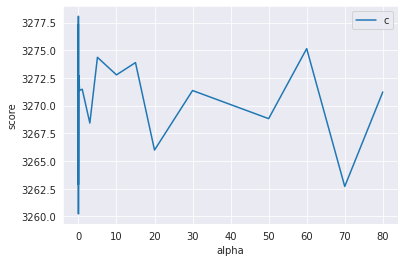

In [0]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

In [0]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(X_train, y_train)

print("Ridge Regression RMSE = ",cv_rmse(ridge_model2).mean())

Ridge Regression RMSE =  3274.981527700181


In [0]:
#Lasso Regression
alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X_train, y_train)

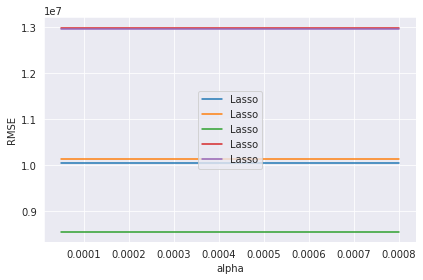

In [0]:
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()


In [0]:
cv_rmse(lasso_model2).mean()

3274.102288334236

In [0]:
#Elastic Net Regression
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(X_train, y_train)

cv_rmse(elastic_model3).mean()


3263.0512029504143

In [0]:
# # XGBoost 
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from xgboost import XGBRegressor

In [0]:
def modelfit(alg, dtrain, target, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, 
                              label=y.values)
        
        print("\nGetting Cross-validation result..")
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print("\nFitting algorithm to data...")
    alg.fit(dtrain, target, eval_metric='rmse')
        
    #Predict training set:
    print("\nPredicting from training data...")
    dtrain_predictions = alg.predict(dtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(target.values,
                                             dtrain_predictions)))

In [0]:
xgb3 = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,max_bin=20,
                     colsample_bytree=0.8,objective= 'reg:squarederror',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X_train, y_train)

NameError: ignored

In [0]:
cv_rmse(xgb_fit).mean()

1357.0202245907417

In [0]:
from sklearn import svm
svr_opt = svm.SVR(C = 100000, gamma = 1e-08)

svr_fit = svr_opt.fit(X_train, y_train)

cv_rmse(svr_fit).mean()

4191.657759309572

In [0]:
#Light GBM
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =20, min_sum_hessian_in_leaf = 11)
lgbm_fit = lgbm_model.fit(X_train, y_train)

cv_rmse(lgbm_fit).mean()

1521.8091155090597

In [0]:
#Stacking
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))


xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.8,objective= 'reg:squarederror',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006))
 

#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgb, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)



#prepare dataframes
stackX = np.array(X_train)
stacky = np.array(y_train)

In [0]:
stack_gen_model = stack_gen.fit(stackX, stacky)

In [0]:
#Predict
em_preds = elastic_model3.predict(X_test)
lasso_preds = lasso_model2.predict(X_test)
ridge_preds = ridge_model2.predict(X_test)
xgb_preds = xgb_fit.predict(X_test)
lgbm_preds = lgbm_fit.predict(X_test)

In [0]:
em_rmse = np.sqrt(mean_squared_error(y_test, em_preds))
la_rmse = np.sqrt(mean_squared_error(y_test, lasso_preds))
ri_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_preds))

In [0]:
print("Elastic Model RMSE: %f" % (em_rmse))
print("Lasso Regression RMSE: %f" % (la_rmse))
print("Ridge Regression RMSE: %f" % (ri_rmse))
print("XGBoost RMSE: %f" % (xgb_rmse))
print("LightGBM RMSE: %f" % (lgbm_rmse))

Elastic Model RMSE: 3228.698971
Lasso Regression RMSE: 3228.746979
Ridge Regression RMSE: 3228.095588
XGBoost RMSE: 1329.498543
LightGBM RMSE: 1421.332274


In [0]:
bm_preds = benchmark_model.predict(X_test)
bm_rmse = np.sqrt(mean_squared_error(y_test, bm_preds))
print("Linear Regression RMSE: %f" % (bm_rmse))

Linear Regression RMSE: 3228.747177


In [0]:
stack_gen_preds = stack_gen_model.predict(X_test)

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = np.sqrt(mean_squared_error(y_test, stack_gen_preds))
print("RMSE: %f" % (rmse))

RMSE: 1401.395620


In [0]:
df_test_xgb = df_test[['Additional_Info', 'Airline', 'Destination', 'Source', 'Date', 'Month',
       'Year', 'Stop', 'Arrival_Hour', 'Arrival_Minute', 'Dep_Hour',
       'Dep_Minute', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']]
preds_1 = stack_gen_model.predict(df_test_xgb)
df_test_xgb['Price'] = preds_1
df_test_xgb.to_csv('flight_price_5.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
df_test_xgb = df_test[['Airline', 'Source', 'Destination', 'Date', 'Month',
       'Year', 'Stop', 'Arrival_Hour', 'Arrival_Minute', 'Dep_Hour',
       'Dep_Minute', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']]
preds_1 = xgb_fit.predict(df_test_xgb)
df_test_xgb['Price'] = preds_1
df_test_xgb.to_csv('flight_price_10.csv')


In [0]:
print (preds_1)

[25320.182 44740.39  14501.77  ... 30599.746 33215.266 27011.234]


In [0]:
df_self = [['Airline'=]]